<a href="https://colab.research.google.com/github/gadgil-group/School_Pb_water/blob/main/NH%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages used in all code
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
from sklearn.neighbors import DistanceMetric
from sklearn.feature_selection import RFE
from scipy import stats
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
#import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.utils import resample
from random import seed
from random import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from numpy import argmax
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import os
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
drive.mount('/content/drive')
import ast

from sklearn.feature_selection import SelectFromModel



##############################################################################################
#Preprocess data
#Dropping all irrelevant categorical columns
#use Imputer to fill in missing feature data with the mean of the column
##############################################################################################
def preprocess_data(df, Pb_threshold, normalize):
    features = df.copy()
    pd.get_dummies(features, columns=['Town'])
    features.drop(columns={ 'Unnamed: 1', 'Alternative Facilty ID*', 'NHDES Facility ID', 
       'Unnamed: 3', 'SAU #/Alias', 'School', 'Address', 'Town', 'lat', 'lon', 'zip code',
       'County', 'State', 'Sample ID', 'Date', 'Time',
       'Sample Location Comments', 'unsafe',  'Parameter/Analyte','Units', 'Result Comments', 'Result',
       'school_address', 'address_lat_lon' }, inplace=True, axis=1)
    # 

    features = features.dropna(how='all', axis=1)

    features=features.replace({'.':np.nan})
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
    labels = df['unsafe']
    features = features.iloc[:, select_features(features, labels)]
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
    #normalize data (optional)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(features)
        features = pd.DataFrame(x_scaled, columns = features.columns)
    return features, labels



Mounted at /content/drive


In [ ]:

##############################################################################################
#Add coordinates
#Add water utility data 
##############################################################################################
lats=[]
lons=[]
Pb_data = pd.read_csv("/content/drive/My Drive/data/NH dataset zip full.csv")
school_addresses=Pb_data['address_lat_lon'].apply(ast.literal_eval)

for address in school_addresses:
  try:
    data = address.get('data')[0]
    lats.append(data.get('latitude'))
    lons.append(data.get('longitude'))
  except IndexError:
    print("Not found")
    lats.append(-9999)
    lons.append(-9999)

Pb_data['lat'] = lats
Pb_data['lon'] = lons

url = 'https://data.epa.gov/efservice/SDW_CONTAM_VIOL_ZIP/STATE/NH/CSV'
result = requests.get(url).content
state_water = pd.read_csv(io.StringIO(result.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)
state_water_relevant = state_water.loc[:,['SDWISDM.SDW_CONTAM_VIOL_ZIP.GEOLOCATION_ZIP'	,'SDWISDM.SDW_CONTAM_VIOL_ZIP.CNAME']]
state_water_aggregate= pd.crosstab(state_water_relevant['SDWISDM.SDW_CONTAM_VIOL_ZIP.GEOLOCATION_ZIP'], state_water_relevant['SDWISDM.SDW_CONTAM_VIOL_ZIP.CNAME'])
state_water_aggregate['Total violations'] = state_water_aggregate.sum(axis=1)
Pb_data = Pb_data.merge(state_water_aggregate, left_on='zip code', right_index=True, how='left')

Not found


In [ ]:

##############################################################################################
#Random forest model - predicts whether Pb leaching is likely to occur in a school based on 
#water quality and socio-economic datA
##############################################################################################
Pb_threshold=15
Pb_data=Pb_data.rename(columns={'school_name':'School'})
Pb_data['unsafe'] = Pb_data['Result']>Pb_threshold

distance_matrix = create_distance_matrix(Pb_data)
features_over_size={}
features, labels = preprocess_data(Pb_data, Pb_threshold, True)
sizes = np.concatenate([np.arange(0.9, 1, 0.05), np.arange(0.9, 0.1, -0.1)])
auc_scores_size=[]
f1_scores_all=[]
y_errors_roc=[]
y_errors_f1=[]
feature_importances=[]

##############################################################################################
#Varying split sizes
##############################################################################################
for size in sizes:
#split features and lables into train and test set
  train_features, test_features, train_labels, test_labels= train_test_split(features, 
      labels, test_size = size, random_state = 42)

  train_features_with_name = train_features.merge(Pb_data[['School']], how='left',  left_index=True, right_index=True).dropna()
  test_features_with_name = test_features.merge(Pb_data[['School']], how='left', left_index=True, right_index=True).dropna()

  test_features['Closest School Pb'] = find_closest_school(Pb_data, test_features_with_name, train_features_with_name, distance_matrix)
  train_features['Closest School Pb'] = find_closest_school(Pb_data, train_features_with_name, train_features_with_name, distance_matrix)

  rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 100, oob_score=True, class_weight={0:1,1:500})

  # Fit model
  rf.fit(train_features.fillna(0), train_labels)

#Define decision threshold for random forest
  threshold = 0.5

  # Predict using selected threshold
  predicted_proba = rf.predict_proba(test_features.fillna(0))
  rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
  # get area under the curve
  roc_auc = auc(fpr, tpr)
  importances = rf.feature_importances_
  feature_lst = list(train_features.columns)
  for i in np.arange(len(feature_lst)):
    if feature_lst[i] in features_over_size.keys():
      features_over_size[feature_lst[i]]+= [importances[i]]
    else:
      features_over_size[feature_lst[i]] = [importances[i]]


                                          

  precision, recall, thresholds = precision_recall_curve(test_labels, predicted_proba[:,1])
  # average precision score
  avg_precision = average_precision_score(test_labels, predicted_proba[:,1])
  # precision auc
  pr_auc = auc(recall, precision)
  #chose best threshold based on f score
  zeros = np.where(precision == 0)
  precision = np.delete(precision, zeros)
  recall = np.delete(recall, zeros)
  thresholds= np.delete(thresholds, zeros)
  fscore = (2 * precision * recall) / (precision + recall)
  fscore = fscore[np.logical_not(np.isnan(fscore))]
  # locate the index of the largest f score
  ix = argmax(fscore)
  cv = ShuffleSplit(n_splits=10, test_size=size, random_state=42)
  rfc_cv_score = cross_val_score(rf, features, labels, cv=cv, scoring='roc_auc')
  rfc_cv_f1 = cross_val_score(rf, features, labels, cv=cv, scoring='f1')

  auc_scores_size.append(np.average(rfc_cv_score))
  f1_scores_all.append(np.average(rfc_cv_f1))

  y_errors_roc.append(stats.sem(rfc_cv_score))
  y_errors_f1.append(stats.sem(rfc_cv_f1))





/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; to

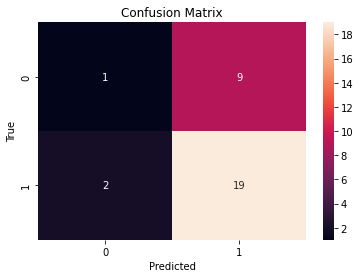

In [ ]:
##############################################################################################
#Hyperparameter optimization
##############################################################################################
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test  = train_test_split(features, labels, test_size=0.3, random_state=1)

n_estimators = [5,20,50,100, 500, 1000, 2000] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
               n_iter =5, cv = 5, verbose=0, random_state=35, scoring='roc_auc')
rf_random.fit(X_train, y_train)
forest = RandomForestClassifier(**rf_random.best_params_) 
forest.fit( X_train, y_train) 
y_pred = forest.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))
print(roc_auc_score( y_test, y_pred))

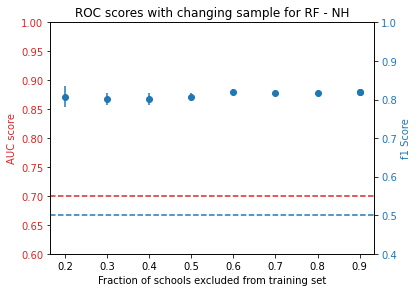

In [ ]:
##############################################################################################
#Plot changes in ROC-AUC, F1 with varying split sizes
##############################################################################################
fig, ax1 = plt.subplots()

color1 = 'tab:red'
ax1.set_xlabel('Fraction of schools excluded from training set')
ax1.set_ylabel('AUC score', color=color1)
ax1.errorbar(x=sizes, y=auc_scores_size, fmt='o', yerr=y_errors_roc, markerfacecolor=color1, markeredgecolor=color1)
ax1.tick_params(axis='y', labelcolor=color1,)
ax1.set_ylim(0.6, 1)
ax1.axhline(y=0.7, color=color1, linestyle='--')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('f1 Score', color=color2)  # we already handled the x-label with ax1
ax2.errorbar(x=sizes, y=f1_scores_all, fmt='o', yerr=y_errors_f1, ecolor=color2);

ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()  # otherwise the right
ax2.set_ylim(0.4, 1)
ax2.axhline(y=0.5, color=color2, linestyle='--')

plt.title('ROC scores with changing sample for RF - NH')

plt.show()

In [ ]:
##############################################################################################
#Feature importance analysis trends over varying split size
##############################################################################################
features_plot = train_features.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features =10
top_features = list(features_plot[i] for i in indices[-num_features:])
for feature in top_features:
  plt.plot(sizes, features_over_size[feature], label=feature)
plt.legend()

In [ ]:
##############################################################################################
#Closest school in each unique training set
##############################################################################################

def create_distance_matrix(data):
  dist = DistanceMetric.get_metric('euclidean')
  data['lat'] = np.radians(data['lat'].values.astype(float))
  data['lon'] = np.radians(data['lon'].values.astype(float))
  distances = pd.DataFrame(dist.pairwise(data[['lat','lon']].to_numpy())*6373,  columns=data['School'], index=data['School'])
  return distances
#Modified find closest algorithm 
def find_closest_school(full_set, x, train_set, distances): 
    x['Closest school with lead'] = np.nan
    schools_in_x = x['School'].tolist()
    schools_with_pb = full_set.loc[full_set['unsafe']==1, 'School'].tolist()
    schools_train_set_with_pb = train_set.loc[train_set['School'].isin(schools_with_pb), 'School'].tolist()
    all_schools = full_set['School'].tolist()
    distances.index = distances.columns.tolist()
    for school in schools_in_x:
        compare_schools = distances[[school]]
        compare_schools.sort_values(by = school, inplace=True)
        compare_schools['School'] = compare_schools.index.astype(str)
        compare_schools = compare_schools[compare_schools['School'].isin(schools_train_set_with_pb)]
        distance_to_school =  compare_schools.iloc[0, :][school]
        i = 1
        while distance_to_school==0:
          distance_to_school =  compare_schools.iloc[i, :][school]
          i = i+1
        x.loc[x['School']==school, 'Closest school with lead'] =distance_to_school

    return x['Closest school with lead']


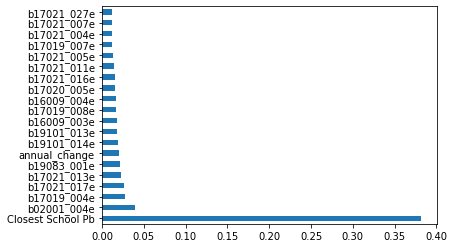

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=train_features.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
##############################################################################################
#Compare extreme split sizes for average importance
##############################################################################################
sizes=[0.2, 0.8]
Pb_threshold=15
Pb_data=Pb_data.rename(columns={'school_name':'School'})
Pb_data['unsafe'] = Pb_data['Result']>Pb_threshold
distance_matrix = create_distance_matrix(Pb_data)
features_over_size={}
features, labels = preprocess_data(Pb_data, Pb_threshold, True)
poverty_and_income = ['b17020', 'b29003', 'b29004', 'b19101', 'b19083', 'b21004', 'b17005']
race = ['b02001']
sex_based_determinants = ['b01001', 'b21004']
household_social_determinants=['b16009','b17019', 'b17021']
utilities_data = state_water_aggregate.columns
cat_feat=pd.DataFrame(columns = ['size', 'category','importance'])

#preprocess data
categories=[poverty_and_income, race, sex_based_determinants,household_social_determinants, utilities_data]
dict_categories=[poverty_and_income, race, sex_based_determinants, household_social_determinants, utilities_data, ['Closest school Pb']]
categories=[poverty_and_income, race, sex_based_determinants,household_social_determinants, utilities_data]
importances_dataframe_ny=pd.DataFrame(index=np.arange(0,6), columns = sizes)

for size in sizes:
  train_features, test_features, train_labels, test_labels= train_test_split(features, 
      labels, test_size = size, random_state = 42)

  train_features_with_name = train_features.merge(Pb_data[['School']], how='left',  left_index=True, right_index=True).dropna()
  test_features_with_name = test_features.merge(Pb_data[['School']], how='left', left_index=True, right_index=True).dropna()

  test_features['Closest School Pb'] = find_closest_school(Pb_data, test_features_with_name, train_features_with_name, distance_matrix)
  train_features['Closest School Pb'] = find_closest_school(Pb_data, train_features_with_name, train_features_with_name, distance_matrix)

  rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 20, oob_score=True, class_weight={0:1,1:100})

  # Fit model
  rf.fit(train_features.fillna(0), train_labels)

#Define decision threshold for random forest
  threshold = 0.5

  # Predict using selected threshold
  predicted_proba = rf.predict_proba(test_features.fillna(0))
  rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
  # get area under the curve
  roc_auc = auc(fpr, tpr)

  ##IMPORTANCES

  importances = rf.feature_importances_
  feature_lst = list(train_features.columns)
  for feature_index in np.arange(0, len(feature_lst)):
    for i in np.arange(0, len(categories)):
      if str.lower(feature_lst[feature_index][:6]) in categories[i] or feature_lst[feature_index] in categories[i]:
        new_val = importances_dataframe_ny.iloc[i, sizes.index(size)]+importances[feature_index]
        importances_dataframe_ny.iloc[i, sizes.index(size)] = new_val
        cat_feat = cat_feat.append(pd.Series({'size':size, 'category':i, 'importance':importances[feature_index]}), ignore_index=True)
      elif feature_lst[feature_index] == 'Closest School Pb':
        importances_dataframe_ny.iloc[5, sizes.index(size)] = importances[feature_index]
        cat_feat = cat_feat.append(pd.Series({'size':size, 'category':5, 'importance':importances[feature_index]}), ignore_index=True)

        break
        


Index(['NHDES Facility ID', 'Unnamed: 1', 'Alternative Facilty ID*',
       'Unnamed: 3', 'SAU #/Alias', 'School', 'Address', 'Town', 'County',
       'State',
       ...
       'Methoxychlor', 'Pentachlorophenol', 'Picloram', 'Tetrachloroethylene',
       'Toxaphene', 'Trichloroethylene', 'Vinyl chloride', 'o-Dichlorobenzene',
       'Total violations', 'unsafe'],
      dtype='object', length=231)


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators

In [ ]:
importances_dataframe_ny.to_csv("/content/drive/My Drive/data/importances_dataframe_nh.csv", index=False)


In [ ]:
cat_feat=cat_feat.groupby(['size', 'category']).agg(lambda x: np.mean(x.sort_values(ascending=False)[:5]))
cat_feat.to_csv("/content/drive/My Drive/data/nh_feature_average_df.csv", index=False)
